## Dependencies

In [1]:
import os
import PIL
import cv2
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from glob import glob

## Verifying Image & Output

In [2]:
df = pd.read_csv('labels.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,./lpd_dataset_v2\lpd_image (1).xml,70,154,151,170
1,./lpd_dataset_v2\lpd_image (10).xml,523,789,396,474
2,./lpd_dataset_v2\lpd_image (100).xml,324,427,310,346
3,./lpd_dataset_v2\lpd_image (1000).xml,365,600,545,616
4,./lpd_dataset_v2\lpd_image (101).xml,280,608,581,677


In [3]:
def get_all_filenames(path):
  return [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".jpg")]

In [19]:
image_paths = get_all_filenames("./lpd_dataset_v2")

In [20]:
image_paths

['./lpd_dataset_v2\\lpd_image (1).jpg',
 './lpd_dataset_v2\\lpd_image (10).jpg',
 './lpd_dataset_v2\\lpd_image (100).jpg',
 './lpd_dataset_v2\\lpd_image (1000).jpg',
 './lpd_dataset_v2\\lpd_image (101).jpg',
 './lpd_dataset_v2\\lpd_image (102).jpg',
 './lpd_dataset_v2\\lpd_image (103).jpg',
 './lpd_dataset_v2\\lpd_image (104).jpg',
 './lpd_dataset_v2\\lpd_image (105).jpg',
 './lpd_dataset_v2\\lpd_image (106).jpg',
 './lpd_dataset_v2\\lpd_image (107).jpg',
 './lpd_dataset_v2\\lpd_image (108).jpg',
 './lpd_dataset_v2\\lpd_image (109).jpg',
 './lpd_dataset_v2\\lpd_image (11).jpg',
 './lpd_dataset_v2\\lpd_image (110).jpg',
 './lpd_dataset_v2\\lpd_image (111).jpg',
 './lpd_dataset_v2\\lpd_image (112).jpg',
 './lpd_dataset_v2\\lpd_image (113).jpg',
 './lpd_dataset_v2\\lpd_image (114).jpg',
 './lpd_dataset_v2\\lpd_image (115).jpg',
 './lpd_dataset_v2\\lpd_image (116).jpg',
 './lpd_dataset_v2\\lpd_image (117).jpg',
 './lpd_dataset_v2\\lpd_image (118).jpg',
 './lpd_dataset_v2\\lpd_image (119).j

In [21]:
image_paths[0]

'./lpd_dataset_v2\\lpd_image (1).jpg'

In [22]:
img = cv2.imread(image_paths[0])

In [24]:
def read_image_with_bounding_box(image_path):
  # Read the image
  img = cv2.imread(image_path)

  # Extract filename without extension
  filename = os.path.splitext(os.path.basename(image_path))[0]

  # Construct the XML file path (assuming same name and location)
  xml_path = os.path.splitext(image_path)[0] + ".xml"

  # Check if XML file exists
  if not os.path.exists(xml_path):
    print(f"XML file not found for image: {image_path}")
    return None

  # Parse the XML file
  try:
    tree = xet.parse(xml_path)
    root = tree.getroot()
  except xet.ParseError as e:
    print(f"Error parsing XML file: {xml_path}")
    return None

  # Get bounding box coordinates
  bounding_box = {}
  for obj in root.findall('object'):
    xmin = int(obj.find('bndbox').find('xmin').text)
    xmax = int(obj.find('bndbox').find('xmax').text)
    ymin = int(obj.find('bndbox').find('ymin').text)
    ymax = int(obj.find('bndbox').find('ymax').text)
    bounding_box = {"xmin": xmin, "xmax": xmax, "ymin": ymin, "ymax": ymax}
    break  # Assuming only one object per image (modify if needed)

  # Create Plotly figure
  fig = px.imshow(img)
  fig.update_layout(width=440, height=330, margin=dict(l=10, r=10, b=10, t=10),
                    xaxis_title='Image with Bounding Box')

  # Add bounding box as a shape (modify as needed)
  if bounding_box:
    fig.add_shape(type='rect', x0=bounding_box['xmin'], x1=bounding_box['xmax'], 
                  y0=bounding_box['ymin'], y1=bounding_box['ymax'],
                  xref='x', yref='y', line_color='red')

  return fig


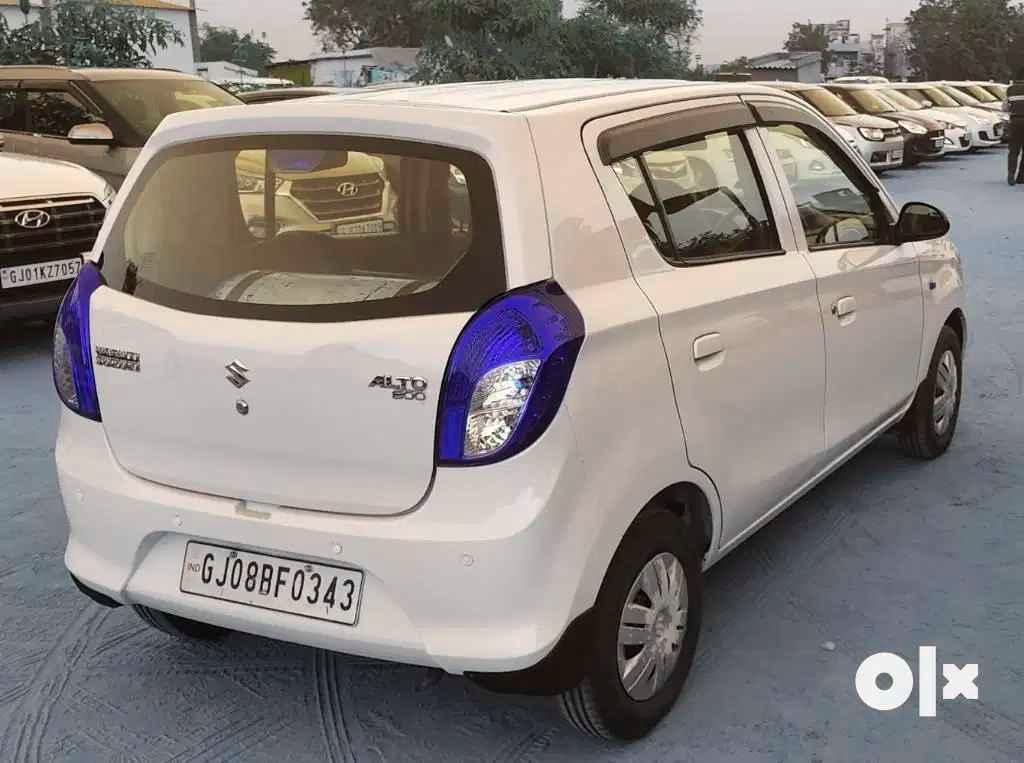

In [27]:
# Example usage
image_path = image_paths[7]
fig = read_image_with_bounding_box(image_path)

if fig:
  fig.show()

## Preproccessing

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

In [28]:
labels = df.iloc[:,1:].values

In [30]:
len(image_paths)

1000

In [34]:
data = []
output = []

for ind in range(len(image_paths)):
    image = image_paths[ind]
    img_arr = cv2.imread(image)
    
    if img_arr is None:
        continue  # Skip to the next iteration if the image could not be read
    
    h, w, d = img_arr.shape
    # preprocessing
    load_image = load_img(image, target_size=(224, 224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr / 255.0  # normalization
    # normalizing to labels
    xmin, xmax, ymin, ymax = labels[ind]
    nxmin, nxmax = xmin / w, xmax / w
    nymin, nymax = ymin / h, ymax / h
    label_norm = (nxmin, nxmax, nymin, nymax)  # normalized output
    # append
    data.append(norm_load_image_arr)
    output.append(label_norm)

## Splitting The Data

In [35]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [36]:
X.shape, y.shape

((1000, 224, 224, 3), (1000, 4))

In [37]:
# Split data into train and test (80-20 split)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Further split training data into train and validation (75-25 split of the 80% training data)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0) 

In [38]:
print("Train shapes:")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("\nValidation shapes:")
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("\nTest shapes:")
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

Train shapes:
x_train shape: (600, 224, 224, 3)
y_train shape: (600, 4)

Validation shapes:
x_val shape: (200, 224, 224, 3)
y_val shape: (200, 4)

Test shapes:
x_test shape: (200, 224, 224, 3)
y_test shape: (200, 4)


## Deep Learning Model (Transfer Learning)

In [41]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential

import tensorflow as tf

In [42]:
input_shape = (224, 224, 3)

# Create the MobileNetV2 model
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Freezing the weights of the base model
base_model.trainable = False

In [47]:
x = Flatten()(base_model.output)

# Add fully connected layers
x = Dense(500, activation='relu')(x)
x = Dense(250, activation='relu')(x)
predictions = Dense(4, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [57]:
# Compile model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])

In [58]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

## Training MobileNetV2 Model

In [49]:
from tensorflow.keras.callbacks import TensorBoard

In [50]:
tfb = TensorBoard('objection_detection_mobile_net_v2')

In [55]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Test Score: %.2f%%" % (scores[1] * 100))

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

## Plotting Scores

In [ ]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    
    epochs = range(len(accuracy))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_scores(train)

## Print Accuracy & Loss

In [ ]:
print("Training Accuracy:", train.history['accuracy'][-1])
print("Validation Accuracy:", train.history['val_accuracy'][-1])
print("Training Loss:", train.history['loss'][-1])
print("Validation Loss:", train.history['val_loss'][-1])

## Saving The Model

In [ ]:
model.save('./models/object_detection_1.h5')